# Partitioned Angle-based Encoding for Quantum Convolutional Filters

In this notebook, I explore a novel approach to encoding input features into rotation angles by partitioning
regions extracted by an unfolding function into subsets and encoding each subset into the available qubits. 

1. **General Quantum Convolutional Layers**:
- Quantum convolutional layers have been proposed and implemented in various forms, 
but they often follow more straightforward encoding schemes where the input data is directly mapped 
onto quantum states without sophisticated partitioning strategies.

- Standard implementations, such as the one provided using Pennylane, typically focus on encoding small, fixed-size regions directly onto qubits.

2. **Partitioning for Efficient Encoding**:

- The idea of partitioning input regions into subsets to be encoded onto different qubits introduces a level of parallelism and scalability that is less common in typical quantum convolutional layer implementations.

- This approach allows for handling larger input sizes and utilizing a limited number of qubits more effectively, which is particularly valuable given the current hardware constraints in quantum computing.

In [62]:
import pennylane as qml
import numpy as np
import torch 
import torch.nn as nn
import  torch.nn.functional as F

from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchvision import transforms

import time

In [63]:
from torch.utils.data import SubsetRandomSampler

# Number of batches
batch_size = 4

# Pre-set data transformations 
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.0,), (1.0,))
])

# MNIST Training and Validation Data
train_data = datasets.FashionMNIST('Train_Set', train = True, transform = transform, download = True)
valid_data = datasets.FashionMNIST('Validation_Set', train = False, transform = transform, download = True)

train_indices = torch.randperm(len(train_data))[:1000]
train_sampler = SubsetRandomSampler(train_indices)
valid_indices = torch.randperm(len(valid_data))[:200]
valid_sampler = SubsetRandomSampler(valid_indices)

# Create Train and Validation DataLoaders
train_loader = DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = 4)
valid_loader = DataLoader(valid_data, batch_size = batch_size, sampler = valid_sampler, num_workers = 4)

c:\Users\Randy\anaconda3\envs\colmap\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [64]:
import matplotlib.pyplot as plt

def display_images(data, suptitle, n = 3, figsize = (10, 10), cmap = 'gray', axis = False):
    """Displays images in a `n x n` grid."""
    fig, ax = plt.subplots(nrows = n, ncols = n, figsize = figsize)
    for i in range(n):
        for j in range(n):
            rand_idx = np.random.randint(0, len(data))
            shape = data[rand_idx][0].shape
            ax[i, j].imshow(torch.permute(data[rand_idx][0], (1, 2, 0)), cmap = cmap)
            ax[i, j].set_title(f'Label: {train_data.classes[data[rand_idx][1]]} | Shape: {(shape[0], shape[1])} | Index: {rand_idx}', size = 8)
            if axis == False:
                ax[i, j].set_axis_off()
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])
    fig.suptitle(suptitle, size = 15)

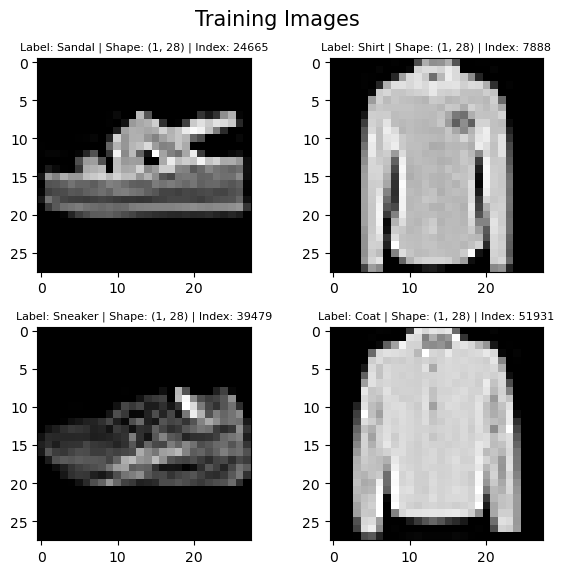

In [65]:
display_images(train_data, 'Training Images', n = 2, figsize = (6, 6), axis = True)

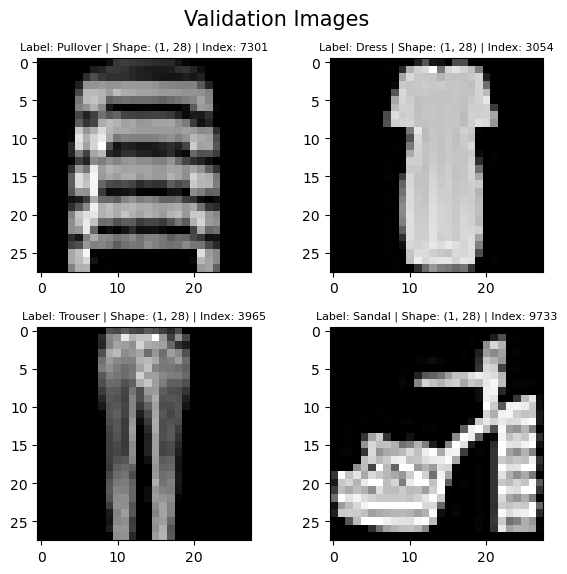

In [66]:
display_images(valid_data, 'Validation Images', n = 2, figsize = (6, 6), axis = True)

In [67]:
class QuantumConv(nn.Module):
    def __init__(self, out_channels, kernel_size, stride, q_device, n_layers = 1, diff_method = 'backprop', params = None):
        super().__init__()
        
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.wires = q_device.wires
        self.n_layers = n_layers

        if params is None:
            params = torch.distributions.uniform.Uniform(low = 0, high = 2 * torch.pi)\
                .sample((n_layers, 8))
        
        self.params = nn.Parameter(params, requires_grad = True)
        self.register_parameter(name = 'RandomLayer Parameters', param = self.params)

        self.qnode = qml.QNode(self.angle_encoding,
                               device = q_device,
                               interface = 'torch',
                               diff_method = 'best')
    
    def __repr__(self):
        return f'QuantumConvOpt({self.out_channels}, kernel_size: ({self.kernel_size}, {self.kernel_size}), stride: ({self.stride}, {self.stride}))'
    
    def angle_encoding(self, phi, wires):
        qml.AngleEmbedding(features = phi, wires = wires, rotation = 'Y')
        qml.RandomLayers(self.params, wires)
        return [qml.expval(qml.PauliZ(wire)) for wire in wires]
    
    def forward(self, x):

        # Get batch_size, number of channels, width, and height of input 
        batch_size, channels, in_width, in_height = x.shape
        out_width = (in_width - self.kernel_size) // self.stride + 1
        out_height = (in_width - self.kernel_size) // self.stride + 1

        # Initialize zero-tensor in shape of output dimensions
        out = torch.zeros((batch_size, self.out_channels, out_width, out_height)).to(self.torch_device)
        regions = F.unfold(x, kernel_size = self.kernel_size, stride = self.stride).to(self.torch_device)

        # Set window step to 1 if only 1 region is extracted
        # Set window step to (n extracted regions // number of available wires) if extracted regions is more than 1
        window_step = 1 if regions.shape[1] == 1 else regions.shape[1] // len(self.wires)

        # Maximum number of outputs that can be generated by quantum circuit
        max_circ_out = window_step * len(self.wires)

        # Number of circuit iterations to reach number of desired output channels
        n_circ_iter = 1 if (self.out_channels // max_circ_out) == 0 else self.out_channels // max_circ_out

        # Number of remaining channels to be generated
        remain = self.out_channels - (max_circ_out * n_circ_iter)
        
        # Iterate through number of batches
        for batch in range(batch_size):
            q_results = [] 
            for n in range(n_circ_iter):
                # Instantiate step count and region subset of shape (n_wires, n_extracted_regions * window_step)
                step, region_subset = 0, torch.zeros(len(self.wires), regions.shape[-1]*window_step)
                
                for idx in range(len(self.wires)):
                    # Extract the regiodn subsets 
                    if regions.shape[1] != 1:
                        region_subset[idx] = regions[batch, step:step+window_step].flatten()
                        step+=window_step
                    else:
                        region_subset[idx] = regions[batch, step].flatten()
                
                # Store quantum convolutions
                q_results += self.qnode(region_subset.T, self.wires)
            
            step = 0
            for result in q_results:
                # Reshape quantum convolutions to output shape
                q_subset = result.reshape((window_step, regions.shape[-1])).reshape((window_step, out_width, out_height))
                out[batch, step:step + window_step, :, :] = q_subset
                step += window_step

            # Remainder handling
            if remain > 0:
                # Get remaining regions and get convolutions
                remain_regions = regions[:, -remain:]
                q_remain = self.qnode(remain_regions[batch].T, self.wires[:remain])
                
                # Reshape results and append to output tensor
                for result in q_remain:
                    out[batch, -remain, :, :] = result.reshape((out_width, out_height))
                    remain -= 1
                remain = 0
        
        return out

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dummy_img = torch.randn((1, 1, 28, 28))
dummy_regions = F.unfold(dummy_img, kernel_size = 1, stride = 1).to(device)

q_device = qml.device('default.qubit.torch', wires = 4, torch_device = device)

In [69]:
channels = 4

classical_conv = nn.Conv2d(in_channels = 1, 
                           out_channels = channels, 
                           kernel_size = 2, 
                           stride = 2).to('cuda')

quant_conv = QuantumConv(out_channels = channels, 
                         kernel_size = 2, 
                         stride = 2, 
                         q_device = q_device, 
                         diff_method = 'backprop').to('cuda')

quant_result = quant_conv(train_data[0][0].unsqueeze(0).to('cuda'))
classical_result = classical_conv(train_data[0][0].unsqueeze(0).to('cuda'))

def plot_convolutions(conv_result, channels = 4, figsize = (13, 8)):
    fig, ax = plt.subplots(1, channels, figsize = figsize)
    for i in range(channels):
        ax[i].imshow(conv_result[0, i, ...].detach().cpu().numpy(), cmap = 'gray')
    fig.tight_layout()

# Classical Convolution Results

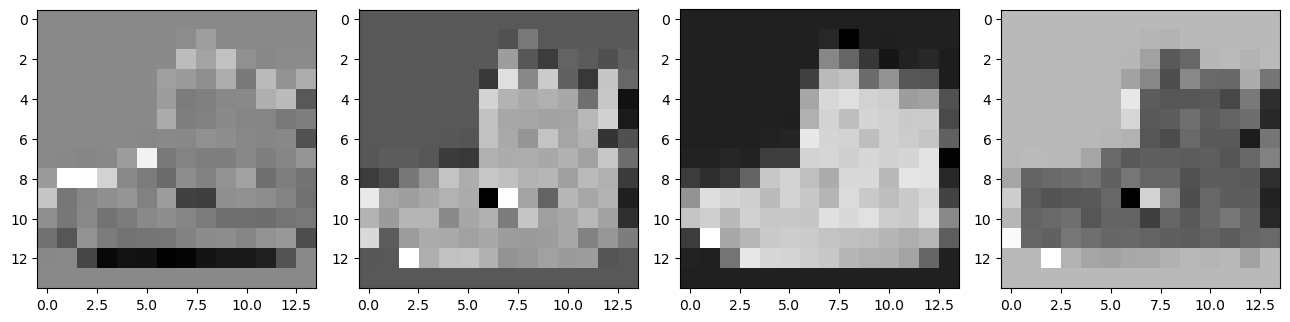

In [70]:
plot_convolutions(classical_result)

# Quantum Convolution Results

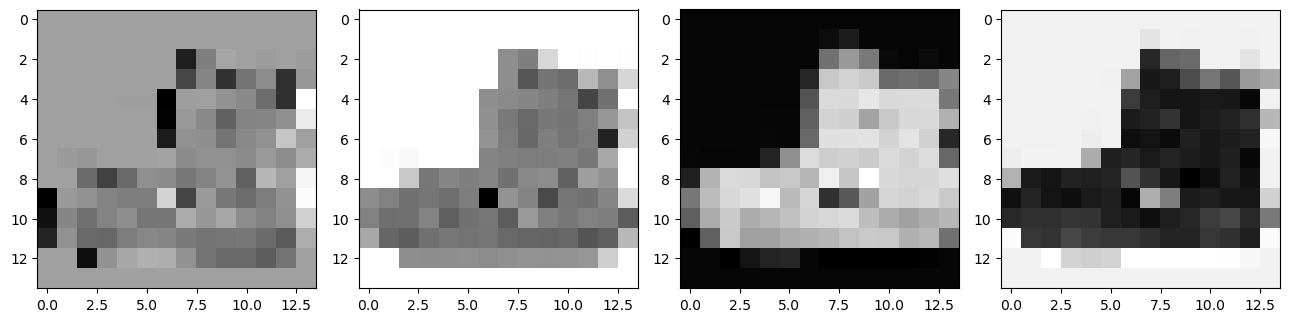

In [71]:
plot_convolutions(quant_result)

Execution Time: 0.25 seconds


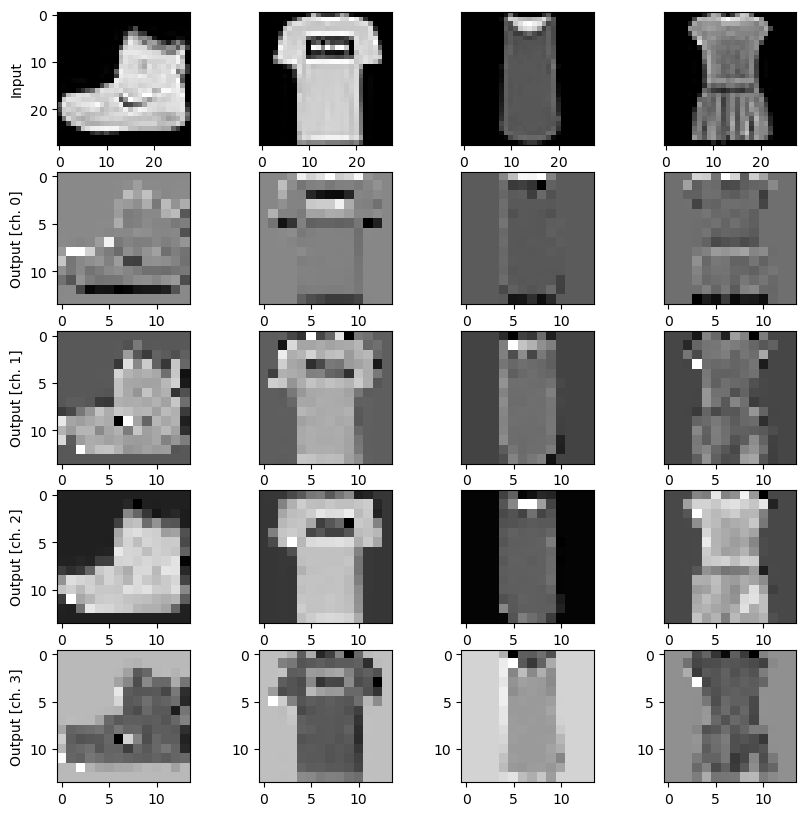

In [72]:
start = time.time()
n_rows, n_cols = 4, 4

fig, ax = plt.subplots(n_rows + 1, n_cols, figsize = (10, 10))
for s in range(n_rows):
    ax[0, 0].set_ylabel('Input', fontsize = 10)

    if s != 0:
        ax[0, s].yaxis.set_visible(False)

    ax[0, s].imshow(torch.permute(train_data[s][0], (1, 2, 0)), cmap = 'gray')

    for c in range(n_cols):
        ax[c + 1, 0].set_ylabel(f'Output [ch. {c}]', fontsize = 10)

        if s != 0:
            ax[c, s].yaxis.set_visible(False)

        ax[c + 1, s].imshow(classical_conv(train_data[s][0].unsqueeze(0).to('cuda'))[0, c, :, :].cpu().detach().numpy(), cmap = 'gray')

end = time.time()

print(f'Execution Time: {end-start:.2f} seconds')

Execution time: 0.60 seconds


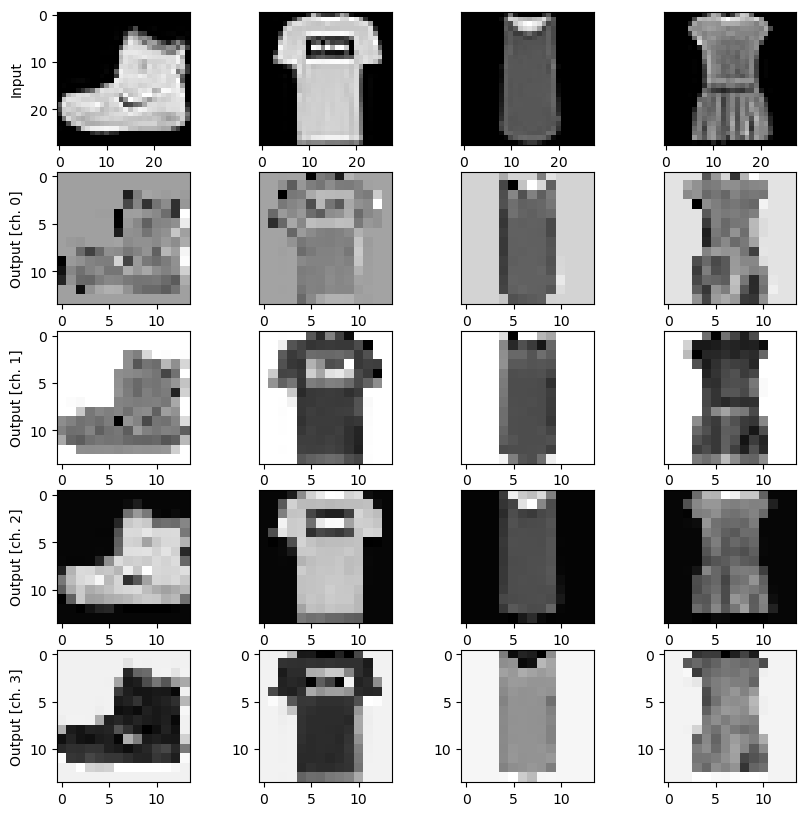

In [73]:
start = time.time()
n_rows, n_cols = 4, 4

fig, ax = plt.subplots(n_rows + 1, n_cols, figsize = (10, 10))
for s in range(n_rows):
    ax[0, 0].set_ylabel('Input', fontsize = 10)

    if s != 0:
        ax[0, s].yaxis.set_visible(False)

    ax[0, s].imshow(torch.permute(train_data[s][0], (1, 2, 0)), cmap = 'gray')

    for c in range(n_cols):
        ax[c + 1, 0].set_ylabel(f'Output [ch. {c}]', fontsize = 10)

        if s != 0:
            ax[c, s].yaxis.set_visible(False)

        ax[c + 1, s].imshow(quant_conv(train_data[s][0].unsqueeze(0).to('cuda'))[0, c, :, :].cpu().detach().numpy(), cmap = 'gray')

end = time.time()
print(f'Execution time: {end-start:.2f} seconds')

In [74]:
class QuantumNet(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, q_device = None):
        super().__init__()

        if q_device is not None:
            self.qconv_1 = QuantumConv(out_channels = 9, kernel_size = 3, stride = stride, q_device = q_device, n_layers = 1)
            in_channels =  9
            # len(q_device.wires)

        self.q_device = q_device

        self.conv_1 = nn.Conv2d(in_channels = in_channels, out_channels = 50, kernel_size = 5, stride = stride) 
        self.pool_1 = nn.MaxPool2d(kernel_size = 2, stride = stride)

        self.conv_2 = nn.Conv2d(in_channels = 50, out_channels = 64, kernel_size = 5, stride = stride)
        self.pool_2 = nn.MaxPool2d(kernel_size = 2, stride = stride)

        self.fc_1 = nn.Linear(in_features = 20736 if q_device is None else 64 * 16**2, out_features = 1024)
        self.fc_2 = nn.Linear(in_features = 1024, out_features = out_channels)

        self.flat = nn.Flatten()
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(p = 0.4) 

    def forward(self, x):
        if self.q_device is not None:
            out = self.qconv_1(x)
            x = out

        out = self.relu(self.conv_1(x))
        out = self.pool_1(out)
        out = self.relu(self.conv_2(out))
        out = self.pool_2(out)

        out = self.flat(out)
        out = self.drop(self.fc_1(out))
        out = self.fc_2(out)

        return F.log_softmax(out, -1)

In [75]:
cnn = QuantumNet(1, len(train_data.classes), q_device = None, stride = 1).to(device)
qcnn = QuantumNet(1, len(train_data.classes), q_device = q_device, stride = 1).to(device)

In [76]:
cnn

QuantumNet(
  (conv_1): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=20736, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.4, inplace=False)
)

In [20]:
qcnn

QuantumNet(
  (qconv_1): QuantumConvOpt(9, kernel_size: (3, 3), stride: (1, 1))
  (conv_1): Conv2d(9, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc_2): Linear(in_features=1024, out_features=10, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.4, inplace=False)
)

In [21]:
train_samples, train_labels = next(iter(train_loader))

In [40]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics import Accuracy, F1Score

epochs = 30
lr = 5e-3
weight_decay = 1e-4

loss_fn = nn.CrossEntropyLoss()

# optim = torch.optim.SGD(qcnn.parameters(), lr = lr, weight_decay = weight_decay)
optim = torch.optim.Adam(cnn.parameters(), lr = lr, weight_decay = weight_decay)

metric_fns = [('Accuracy', Accuracy(task = 'multiclass', num_classes = len(train_data.classes)).to(device)),
              ('F1Score', F1Score(task = 'multiclass', average = 'macro', num_classes = len(train_data.classes)).to(device))]

scheduler = CosineAnnealingLR(optim, T_max = epochs)

In [38]:
def calculate_metrics(metric_fns, y_pred, y):
    results = {}
    for metric_fn in metric_fns:
        if metric_fn[0] not in results:
            results[metric_fn[0]] = 0
        results[metric_fn[0]] = metric_fn[1](y_pred, y)
    return results 

In [39]:
def train_step(model, dataloader, optimizer, loss_fn, metric_fns, device, scheduler = None):
    loss = 0
    metric_scores = {}

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        
        y = y.long()

        # Calculate metrics
        train_loss = loss_fn(y_pred, y)
        metric_results = calculate_metrics(metric_fns, y_pred, y)
        
        # Aggregate metrics
        loss += train_loss

        for result in metric_results.items():
            if result[0] not in metric_scores:
                metric_scores[result[0]] = 0
            metric_scores[result[0]] += result[1]

        # Reset gradients
        optimizer.zero_grad()
        
        # Backpropagation
        train_loss.backward()
        
        # Print parameters before optimizer step
        # print(f'Before Optimizer Step: {qnn.qconv_1.params.grad}')

        # Gradient descent
        optimizer.step()

        # Print parameters after optimizer step
        # print(f'After Optimizer Step: {qnn.qconv_1.params.grad}')

    # Calculate average metrics
    loss /= len(dataloader)

    print(f'Training   | Loss: {loss.item():.4f}\n')
    for score in metric_scores.items():
        metric_scores[score[0]] = score[1].cpu().item()/len(dataloader)
        print(f'{score[0]} : {metric_scores[score[0]]:.4f}')

    return loss.cpu().item(), metric_scores

def valid_step(model, dataloader, loss_fn, metric_fns, device):
    loss = 0
    metric_scores = {}

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            
            y = y.long()

            valid_loss = loss_fn(y_pred, y)
            metric_results = calculate_metrics(metric_fns, y_pred, y)

            loss += valid_loss

            for result in metric_results.items():
                if result[0] not in metric_scores:
                    metric_scores[result[0]] = 0
                metric_scores[result[0]] += result[1]

        loss /= len(dataloader)
        
    print(f'Validation | Loss: {loss:.4f}\n')
    for score in metric_scores.items():
        metric_scores[score[0]] = score[1].cpu().item()/len(dataloader)
        print(f'{score[0]} : {metric_scores[score[0]]:.4f}')

    return loss.cpu().item(), metric_scores

In [32]:
def train_and_validate(model, train_dataloader, valid_dataloader, n_epochs, loss_fn, metric_fns, optim, device, scheduler = None):
    train_losses = []
    valid_losses = []

    train_scores = {}
    valid_scores = {}

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch}')
        print('-'*40+'\n')
        
        train_loss, train_metrics = train_step(model, 
                                               train_dataloader,
                                               optim, 
                                               loss_fn,
                                               metric_fns,
                                               device)
        train_losses.append(train_loss)
        
        for score in train_metrics.items():
            if score[0] not in train_scores:
                train_scores[score[0]] = []
            train_scores[score[0]].append(score[1])

        print('\n')

        valid_loss, valid_metrics = valid_step(model,
                                               valid_dataloader,
                                               loss_fn,
                                               metric_fns,
                                               device)
        valid_losses.append(valid_loss)

        for score in valid_metrics.items():
            if score[0] not in valid_scores:
                valid_scores[score[0]] = []
            valid_scores[score[0]].append(score[1])
        
        if scheduler is not None:
            scheduler.step()

        print('\n')
    
    return (train_losses, valid_losses), (train_scores, valid_scores)

In [36]:
qcnn_losses, qcnn_scorse = train_and_validate(qcnn, 
                                              train_loader, 
                                              valid_loader, 
                                              epochs, 
                                              loss_fn, 
                                              metric_fns, 
                                              optim, 
                                              device, 
                                              scheduler)

Epoch: 0
----------------------------------------



c:\Users\Randy\anaconda3\envs\colmap\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training   | Loss: 1.8407

Accuracy : 0.3770
Precision : 0.2800


Validation | Loss: 0.8845

Accuracy : 0.7450
Precision : 0.6314


Epoch: 1
----------------------------------------

Training   | Loss: 0.6898

Accuracy : 0.7780
Precision : 0.6921


Validation | Loss: 0.4952

Accuracy : 0.8700
Precision : 0.8127


Epoch: 2
----------------------------------------

Training   | Loss: 0.4572

Accuracy : 0.8520
Precision : 0.7892


Validation | Loss: 0.4352

Accuracy : 0.8850
Precision : 0.8287


Epoch: 3
----------------------------------------

Training   | Loss: 0.3224

Accuracy : 0.8910
Precision : 0.8402


Validation | Loss: 0.4348

Accuracy : 0.8850
Precision : 0.8315


Epoch: 4
----------------------------------------

Training   | Loss: 0.2449

Accuracy : 0.9190
Precision : 0.8811


Validation | Loss: 0.3660

Accuracy : 0.9000
Precision : 0.8628


Epoch: 5
----------------------------------------

Training   | Loss: 0.1874

Accuracy : 0.9370
Precision : 0.9080


Validation | Loss: 

In [41]:
cnn_losses, cnn_scores = train_and_validate(cnn, 
                                            train_loader, 
                                            valid_loader, 
                                            epochs, 
                                            loss_fn, 
                                            metric_fns, 
                                            optim, 
                                            device, 
                                            scheduler)

Epoch: 0
----------------------------------------

Training   | Loss: 1.4578

Accuracy : 0.5120
F1Score : 0.4104


Validation | Loss: 0.6157

Accuracy : 0.8050
F1Score : 0.7231


Epoch: 1
----------------------------------------

Training   | Loss: 0.5045

Accuracy : 0.8400
F1Score : 0.7695


Validation | Loss: 0.4572

Accuracy : 0.9000
F1Score : 0.8476


Epoch: 2
----------------------------------------

Training   | Loss: 0.3431

Accuracy : 0.8970
F1Score : 0.8462


Validation | Loss: 0.3497

Accuracy : 0.9150
F1Score : 0.8636


Epoch: 3
----------------------------------------

Training   | Loss: 0.2349

Accuracy : 0.9320
F1Score : 0.8964


Validation | Loss: 0.3081

Accuracy : 0.9150
F1Score : 0.8631


Epoch: 4
----------------------------------------

Training   | Loss: 0.1767

Accuracy : 0.9430
F1Score : 0.9116


Validation | Loss: 0.3264

Accuracy : 0.9200
F1Score : 0.8822


Epoch: 5
----------------------------------------

Training   | Loss: 0.1391

Accuracy : 0.9530
F1Score :

In [55]:
def smooth_curve(loss_values, factor = 0.8):
    smoothed_loss = [loss_values[0]]
    for value in loss_values[1:]:
        smoothed_loss.append(smoothed_loss[-1] * factor + value * (1 - factor))
    return smoothed_loss

C:\Users\Randy\AppData\Local\Temp\ipykernel_119972\634254656.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


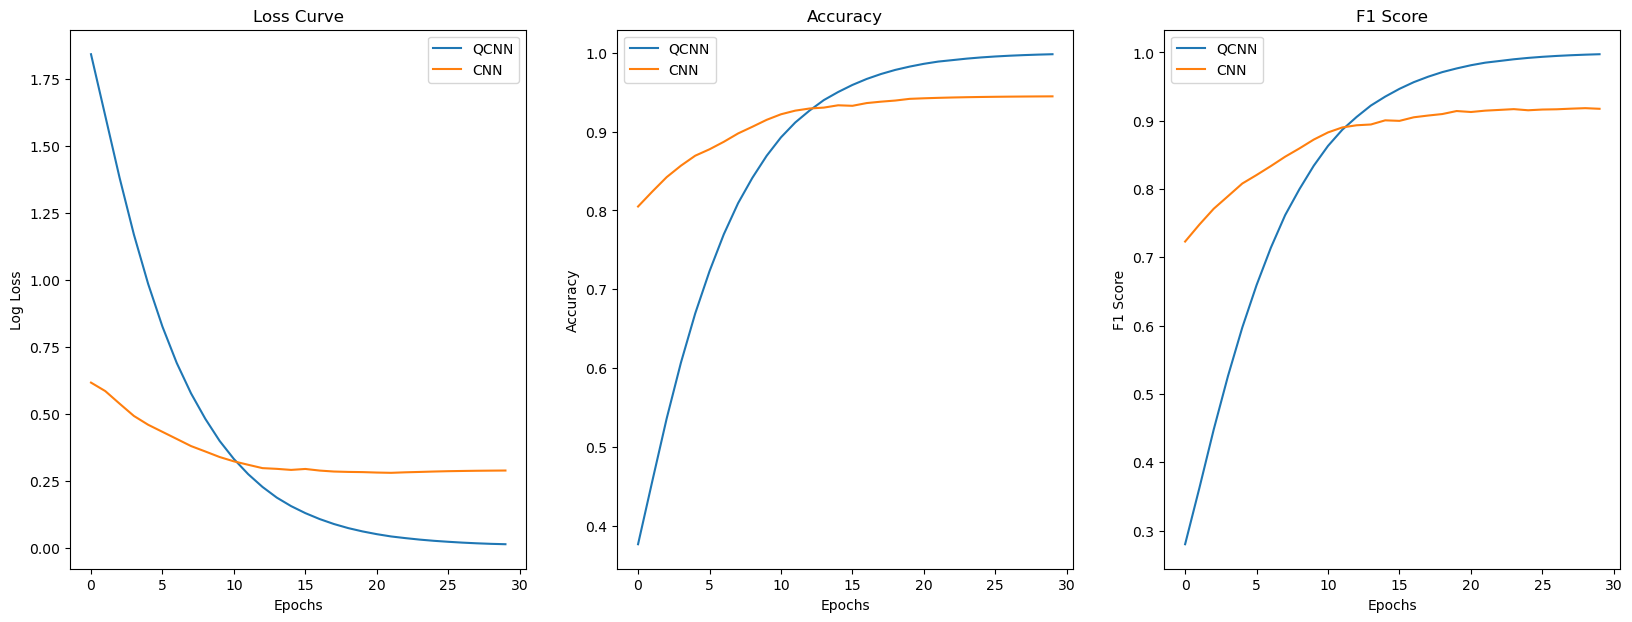

In [61]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

ax[0].plot(np.arange(epochs), smooth_curve(qcnn_losses[0]), label = 'QCNN')
ax[0].plot(np.arange(epochs), smooth_curve(cnn_losses[1]), label = 'CNN')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log Loss')
ax[0].legend()
ax[0].set_title('Loss Curve')

ax[1].plot(np.arange(epochs), smooth_curve(qcnn_scores[0]['Accuracy']), label = 'QCNN')
ax[1].plot(np.arange(epochs), smooth_curve(cnn_scores[1]['Accuracy']), label = 'CNN')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')

ax[2].plot(np.arange(epochs), smooth_curve(qcnn_scores[0]['F1Score']), label = 'QCNN')
ax[2].plot(np.arange(epochs), smooth_curve(cnn_scores[1]['F1Score']), label = 'CNN')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('F1 Score')
ax[2].legend()
ax[2].set_title('F1 Score')

fig.show()